In [1]:
import os
os.chdir("/Users/asahoo/repos/PASTIS")
import time
from shutil import copy

from astropy.io import fits
import astropy.units as u
import hcipy
import numpy as np

import pastis.util as util    
from pastis.config import CONFIG_PASTIS 
from pastis.e2e_simulators.luvoir_imaging import LuvoirA_APLC 
from pastis.e2e_simulators.generic_segmented_telescopes import SegmentedAPLC
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

### Define and create directory

In [2]:
root_dir = "/Users/asahoo/Desktop/data_repos/harris_data"
repo_dir = "/Users/asahoo/repos/PASTIS"
coronagraph_design = 'small' # user provides
overall_dir = util.create_data_path(root_dir, telescope='luvoir_'+coronagraph_design)
resDir = os.path.join(overall_dir, 'matrix_numerical')
print(resDir)


# Create necessary directories if they don't exist yet
os.makedirs(resDir, exist_ok=True)
os.makedirs(os.path.join(resDir, 'OTE_images'), exist_ok=True)
os.makedirs(os.path.join(resDir, 'psfs'), exist_ok=True)

/Users/asahoo/Desktop/data_repos/harris_data

/Users/asahoo/Desktop/data_repos/harris_data/2021-06-02T19-59-53_luvoir_small/matrix_numerical


### Read from configfile 

In [3]:
max_LO = CONFIG_PASTIS.getint('dm_objects', 'number_of_low_order_modes')
max_MID = CONFIG_PASTIS.getint('dm_objects', 'number_of_mid_order_modes')
max_HI = CONFIG_PASTIS.getint('dm_objects', 'number_of_high_order_modes')
num_DM_act = CONFIG_PASTIS.getint('dm_objects', 'number_of_continuous_dm_actuators')

nb_seg = CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_PASTIS.getfloat('LUVOIR', 'lambda') * 1e-9  # m
diam = CONFIG_PASTIS.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_PASTIS.getfloat('LUVOIR', 'calibration_aberration') * 1e-9   # m
sampling = CONFIG_PASTIS.getfloat('LUVOIR', 'sampling')
coronagraph_design = CONFIG_PASTIS.get('LUVOIR','coronagraph_design')

optics_path_in_repo = CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo')
aper_path = CONFIG_PASTIS.get('LUVOIR','aperture_path_in_optics')
aper_ind_path = CONFIG_PASTIS.get('LUVOIR', 'indexed_aperture_path_in_optics')
aper_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_path))
aper_ind_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))
z_pup_downsample = CONFIG_PASTIS.getfloat('numerical', 'z_pup_downsample') 

### Load aperture files to make segmented mirror

In [4]:
pupil_grid = hcipy.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hcipy.Field(aper_read.ravel(), pupil_grid)
aper_ind = hcipy.Field(aper_ind_read.ravel(), pupil_grid)
wf_aper = hcipy.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))

poslist = []
for i in range(nb_seg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hcipy.CartesianGrid(hcipy.UnstructuredCoords(poslist))

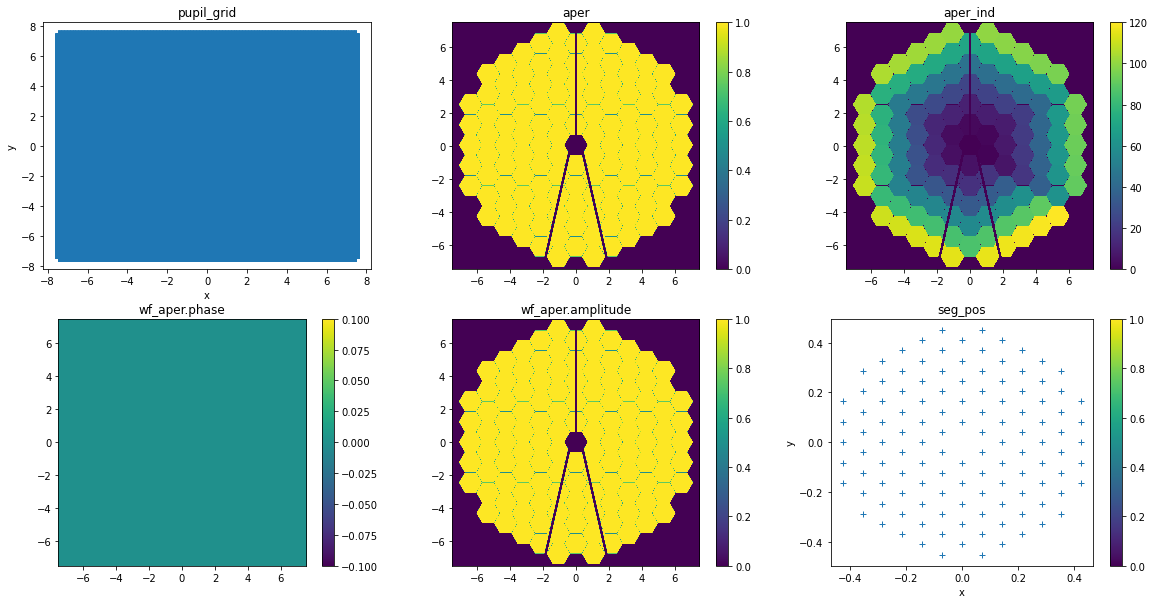

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("pupil_grid")
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2,3,2)
plt.title("aper")
hcipy.imshow_field(aper)
plt.colorbar()

plt.subplot(2,3,3)
plt.title("aper_ind")
hcipy.imshow_field(aper_ind)
plt.colorbar()

plt.subplot(2,3,4)
plt.title("wf_aper.phase")
hcipy.imshow_field(wf_aper.phase)
plt.colorbar()

plt.subplot(2,3,5)
plt.title("wf_aper.amplitude")
hcipy.imshow_field(wf_aper.amplitude)
plt.colorbar()

plt.subplot(2,3,6)
plt.title("seg_pos")
plt.plot(seg_pos.x, seg_pos.y, '+')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

### Print from configfile

In [6]:
print(f'max_LO: {max_LO}')
print(f'max_MID: {max_MID}')
print(f'max_HI: {max_HI}')
print(f'num_DM_act: {num_DM_act}')
print('LUVOIR apodizer design: {}'.format(coronagraph_design)) 
print()
print('Wavelength: {} m'.format(wvln))
print('Telescope diameter: {} m'.format(diam))
print('Number of segments: {}'.format(nb_seg))
print()
print('Sampling: {} px per lambda/D'.format(sampling))

max_LO: 15
max_MID: 1
max_HI: 4
num_DM_act: 4
LUVOIR apodizer design: small

Wavelength: 5.000000000000001e-07 m
Telescope diameter: 15.0 m
Number of segments: 120

Sampling: 4.0 px per lambda/D


### Instantiate LUVOIR

In [7]:
optics_input = os.path.join(util.find_repo_location(), CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo'))
luvoir = LuvoirA_APLC(optics_input, coronagraph_design, sampling)

/opt/miniconda3/envs/pastis_global/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


In [8]:
N_pup_z = np.int(luvoir.pupil_grid.shape[0] / z_pup_downsample)
grid_zernike = hcipy.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)

### load thermal modes files

In [9]:
filepath = "/Users/asahoo/repos/PASTIS/Jupyter Notebooks/LUVOIR/Sensitivities2.xlsx"
pad_orientation = np.pi/2*np.ones(nb_seg)
#pad_orientation = np.zeros(nb_seg)

### create harris deformabale mirror

In [10]:
luvoir.create_segmented_harris_mirror(filepath,pad_orientation) 
luvoir.harris_sm

### creating single segment

In [11]:
segment = hcipy.hexagonal_aperture(luvoir.segment_circumscribed_diameter, np.pi/2)
segment_sampled = hcipy.evaluate_supersampled(segment,luvoir.pupil_grid, 1)

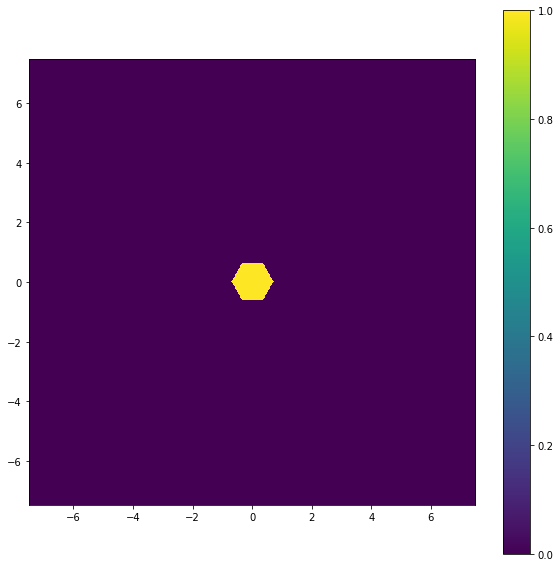

In [12]:
plt.figure(figsize=(10, 10))
hcipy.imshow_field(segment_sampled)
plt.colorbar()

### creating nb_seg segments

In [13]:
aper2, segs2 = hcipy.make_segmented_aperture(segment,luvoir.seg_pos, segment_transmissions=1, return_segments=True)
luvoir_segmented_pattern = hcipy.evaluate_supersampled(aper2, luvoir.pupil_grid, 1)
seg_evaluated = []
for seg_tmp in segs2:
    tmp_evaluated = hcipy.evaluate_supersampled(seg_tmp, luvoir.pupil_grid, 1)
    seg_evaluated.append(tmp_evaluated)

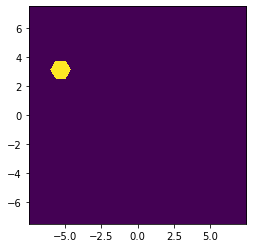

In [14]:
hcipy.imshow_field(seg_evaluated[75])

In [15]:
luvoir.pupil_grid.coords

In [ ]:
df = pd.read_excel(filepath)
A = np.asarray(df.a)
B = np.asarray(df.b)
C = np.asarray(df.c)
D = np.asarray(df.d)
E = np.asarray(df.e)
F = np.asarray(df.f)
G = np.asarray(df.g)
H = np.asarray(df.h)
I = np.asarray(df.i)
J = np.asarray(df.j)
K = np.asarray(df.k)

X = np.asarray(df.X)
Y = np.asarray(df.Y)
HarrisDiam = luvoir.harris_seg_diameter
pup_dims = luvoir.pupil_grid.dims
X = np.asarray(df.X)*luvoir.segment_circumscribed_diameter/HarrisDiam
Y = np.asarray(df.Y)*luvoir.segment_circumscribed_diameter/HarrisDiam

ti = np.linspace(-0.5,0.5,pup_dims[0])*luvoir.diam
points = np.transpose(np.asarray([X,Y]))
valuesA = A
valuesB = B
valuesC = C
valuesD = D
valuesE = E
valuesF = F
valuesG = G
valuesH = H
valuesI = I
valuesJ = J
valuesK = K
XI, YI = np.meshgrid(ti, ti)

xL1D = luvoir.pupil_grid.x
yL1D = luvoir.pupil_grid.y
xL1D = np.asarray(xL1D)
yL1D = np.asarray(yL1D)

In [ ]:
HarrisBase_Thermal = []
for seg_num in range(0, 120):
    print(seg_num)
    grid_seg = luvoir.pupil_grid.shifted(-luvoir.seg_pos[seg_num])
    xL1D = grid_seg.x
    yL1D = grid_seg.y
    xL1D = np.asarray(xL1D)
    yL1D = np.asarray(yL1D)
    phi = pad_orientation[seg_num]
    XRot = xL1D * np.cos(phi) + yL1D * np.sin(phi)
    YRot = -xL1D * np.sin(phi) + yL1D * np.cos(phi)
    ZA = griddata(points, valuesA, (XRot, YRot), method='linear')
    ZA[np.isnan(ZA)]=0
    ZA = ZA.ravel()*seg_evaluated[seg_num]
    ZH = griddata(points, valuesH, (XRot, YRot), method='linear')
    ZH[np.isnan(ZH)]=0
    ZH = ZH.ravel()*seg_evaluated[seg_num]
    ZI = griddata(points, valuesI, (XRot, YRot), method='linear')
    ZI[np.isnan(ZI)]=0
    ZI = ZI.ravel()*seg_evaluated[seg_num]
    ZJ = griddata(points, valuesJ, (XRot, YRot), method='linear')
    ZJ[np.isnan(ZJ)]=0
    ZJ = ZJ.ravel()*seg_evaluated[seg_num]
    ZK = griddata(points, valuesK, (XRot, YRot), method='linear')
    ZK[np.isnan(ZK)]=0
    ZK = ZK.ravel()*seg_evaluated[seg_num]
    HarrisBase_Thermal.append([ZA,ZH,ZI,ZJ,ZK])
HarrisBase_Thermal = np.asarray(HarrisBase_Thermal)
N_segs= HarrisBase_Thermal.shape[0]
N_single_modes= HarrisBase_Thermal.shape[1]
HarrisBase_Thermal = HarrisBase_Thermal.reshape(N_segs*N_single_modes,pup_dims[0]**2)
Harris_Thermal_ModeBasis = hcipy.ModeBasis(np.transpose(HarrisBase_Thermal),grid = pupil_grid)

In [ ]:
hcipy.imshow_field(Harris_Thermal_ModeBasis[20])

In [ ]:
hcipy.imshow_field(HarrisBase_Thermal[4]-seg_evaluated[100])

In [ ]:
# N_Modes_Harris = Harris_Thermal_ModeBasis.num_modes
# qqq = 265
# zernike_coeffs = np.zeros([N_Modes_Harris])
# zernike_coeffs[qqq] = 1e-12
# harris_sm.actuators = zernike_coeffs
# wf_sm = harris_sm(luvoir.wf_aper)
# # plt.figure(figsize=(10, 10))
# # hcipy.imshow_field(wf_sm.phase)
# zernike_coeffs = np.zeros([N_Modes_Harris])
# zernike_coeffs[qqq] = 1e-12
# luvoir.sm.actuators = zernike_coeffs
# wf_sm2 = luvoir.sm(luvoir.wf_aper)

# # plt.figure(figsize=(10, 10))
# # hcipy.imshow_field(wf_sm2.phase)
# plt.figure(figsize=(10, 10))
# hcipy.imshow_field(wf_sm2.phase - wf_sm.phase)

### Flatten all DMs and create unaberrated reference PSF

In [19]:
n_harris = luvoir.harris_sm.num_actuators
harris_mode =np.zeros(n_harris)
luvoir.harris_sm.actuators = harris_mode

In [21]:
len(harris_mode)

1320

### Calculate the unaberrated coro and direct PSFs in INTENSITY

In [22]:
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False)

In [23]:
norm = np.max(ref)

In [24]:
# Calculate the unaberrated coro and direct PSFs in E-FIELDS
nonaberrated_coro_psf, ref, efield = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield')
Efield_ref = nonaberrated_coro_psf.electric_field

In [26]:
print('Generating the E-fields for harris modes in science plane')


Generating the E-fields for harris modes in science plane


In [27]:
print(f'Calibration aberration used: {nm_aber} m')
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []

Calibration aberration used: 1e-09 m


In [28]:
for pp in range(0, n_harris):
    print(f'Working on mode {pp}/{n_harris}')
    
    # Apply calibration aberration to used mode
    harris_mode = np.zeros(n_harris)
    harris_mode[pp] = nm_aber / 2
    luvoir.harris_sm.actuators  = harris_mode
    
    # Calculate coronagraphic E-field and add to lists
    aberrated_coro_psf, inter = luvoir.calc_psf(display_intermediate=False, return_intermediate='efield')
    focus_field1 = aberrated_coro_psf
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

Working on mode 0/1320
Working on mode 1/1320
Working on mode 2/1320
Working on mode 3/1320
Working on mode 4/1320
Working on mode 5/1320
Working on mode 6/1320
Working on mode 7/1320
Working on mode 8/1320
Working on mode 9/1320
Working on mode 10/1320
Working on mode 11/1320
Working on mode 12/1320
Working on mode 13/1320
Working on mode 14/1320
Working on mode 15/1320
Working on mode 16/1320
Working on mode 17/1320
Working on mode 18/1320
Working on mode 19/1320
Working on mode 20/1320
Working on mode 21/1320
Working on mode 22/1320
Working on mode 23/1320
Working on mode 24/1320
Working on mode 25/1320
Working on mode 26/1320
Working on mode 27/1320
Working on mode 28/1320
Working on mode 29/1320
Working on mode 30/1320
Working on mode 31/1320
Working on mode 32/1320
Working on mode 33/1320
Working on mode 34/1320
Working on mode 35/1320
Working on mode 36/1320
Working on mode 37/1320
Working on mode 38/1320
Working on mode 39/1320
Working on mode 40/1320
Working on mode 41/1320
Wo

Working on mode 333/1320
Working on mode 334/1320
Working on mode 335/1320
Working on mode 336/1320
Working on mode 337/1320
Working on mode 338/1320
Working on mode 339/1320
Working on mode 340/1320
Working on mode 341/1320
Working on mode 342/1320
Working on mode 343/1320
Working on mode 344/1320
Working on mode 345/1320
Working on mode 346/1320
Working on mode 347/1320
Working on mode 348/1320
Working on mode 349/1320
Working on mode 350/1320
Working on mode 351/1320
Working on mode 352/1320
Working on mode 353/1320
Working on mode 354/1320
Working on mode 355/1320
Working on mode 356/1320
Working on mode 357/1320
Working on mode 358/1320
Working on mode 359/1320
Working on mode 360/1320
Working on mode 361/1320
Working on mode 362/1320
Working on mode 363/1320
Working on mode 364/1320
Working on mode 365/1320
Working on mode 366/1320
Working on mode 367/1320
Working on mode 368/1320
Working on mode 369/1320
Working on mode 370/1320
Working on mode 371/1320
Working on mode 372/1320


Working on mode 661/1320
Working on mode 662/1320
Working on mode 663/1320
Working on mode 664/1320
Working on mode 665/1320
Working on mode 666/1320
Working on mode 667/1320
Working on mode 668/1320
Working on mode 669/1320
Working on mode 670/1320
Working on mode 671/1320
Working on mode 672/1320
Working on mode 673/1320
Working on mode 674/1320
Working on mode 675/1320
Working on mode 676/1320
Working on mode 677/1320
Working on mode 678/1320
Working on mode 679/1320
Working on mode 680/1320
Working on mode 681/1320
Working on mode 682/1320
Working on mode 683/1320
Working on mode 684/1320
Working on mode 685/1320
Working on mode 686/1320
Working on mode 687/1320
Working on mode 688/1320
Working on mode 689/1320
Working on mode 690/1320
Working on mode 691/1320
Working on mode 692/1320
Working on mode 693/1320
Working on mode 694/1320
Working on mode 695/1320
Working on mode 696/1320
Working on mode 697/1320
Working on mode 698/1320
Working on mode 699/1320
Working on mode 700/1320


Working on mode 989/1320
Working on mode 990/1320
Working on mode 991/1320
Working on mode 992/1320
Working on mode 993/1320
Working on mode 994/1320
Working on mode 995/1320
Working on mode 996/1320
Working on mode 997/1320
Working on mode 998/1320
Working on mode 999/1320
Working on mode 1000/1320
Working on mode 1001/1320
Working on mode 1002/1320
Working on mode 1003/1320
Working on mode 1004/1320
Working on mode 1005/1320
Working on mode 1006/1320
Working on mode 1007/1320
Working on mode 1008/1320
Working on mode 1009/1320
Working on mode 1010/1320
Working on mode 1011/1320
Working on mode 1012/1320
Working on mode 1013/1320
Working on mode 1014/1320
Working on mode 1015/1320
Working on mode 1016/1320
Working on mode 1017/1320
Working on mode 1018/1320
Working on mode 1019/1320
Working on mode 1020/1320
Working on mode 1021/1320
Working on mode 1022/1320
Working on mode 1023/1320
Working on mode 1024/1320
Working on mode 1025/1320
Working on mode 1026/1320
Working on mode 1027/13

Working on mode 1305/1320
Working on mode 1306/1320
Working on mode 1307/1320
Working on mode 1308/1320
Working on mode 1309/1320
Working on mode 1310/1320
Working on mode 1311/1320
Working on mode 1312/1320
Working on mode 1313/1320
Working on mode 1314/1320
Working on mode 1315/1320
Working on mode 1316/1320
Working on mode 1317/1320
Working on mode 1318/1320
Working on mode 1319/1320


In [29]:
# Construct the PASTIS matrix from the E-fields
mat_fast = np.zeros([n_harris, n_harris])   # create empty matrix

for i in range(0, n_harris):
    for j in range(0, n_harris):
        test = np.real((focus_fieldS[i].electric_field - Efield_ref) * np.conj(focus_fieldS[j].electric_field - Efield_ref))
        dh_test = (test / norm) * luvoir.dh_mask
        contrast = np.mean(dh_test[np.where(luvoir.dh_mask != 0)])
        mat_fast[i, j] = contrast

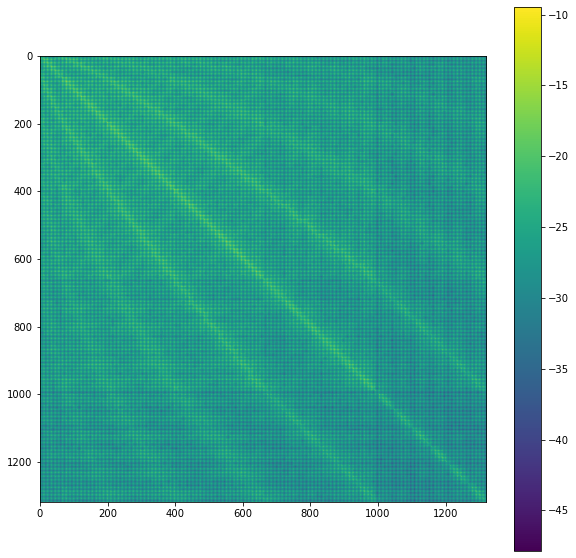

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs((mat_fast))))
plt.colorbar()

In [37]:
matrix_pastis = np.copy(mat_fast)
matrix_pastis /= np.square(nm_aber * 1e9)

In [38]:
filename_matrix = 'PASTISmatrix_n_harris_' + str(n_harris)
hcipy.write_fits(matrix_pastis, os.path.join(resDir, filename_matrix + '.fits'))
print('Matrix saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Matrix saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-06-02T19-59-53_luvoir_small/matrix_numerical/PASTISmatrix_n_harris_1320.fits


In [39]:
filename_matrix = 'EFIELD_Re_matrix_n_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Real saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-06-02T19-59-53_luvoir_small/matrix_numerical/EFIELD_Re_matrix_n_harris_1320.fits


In [40]:
filename_matrix = 'EFIELD_Im_matrix_n_harris_' + str(max_LO)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Imag saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-06-02T19-59-53_luvoir_small/matrix_numerical/EFIELD_Im_matrix_n_harris_15.fits


In [41]:
end_time = time.time()

In [43]:
print('Runtime for harris modes:', end_time - start_time, 'sec =', (end_time - start_time) / 60, 'min')
print('Data saved to {}'.format(resDir))

Runtime for harris modes: 6069.371083021164 sec = 101.1561847170194 min
Data saved to /Users/asahoo/Desktop/data_repos/harris_data/2021-06-02T19-59-53_luvoir_small/matrix_numerical


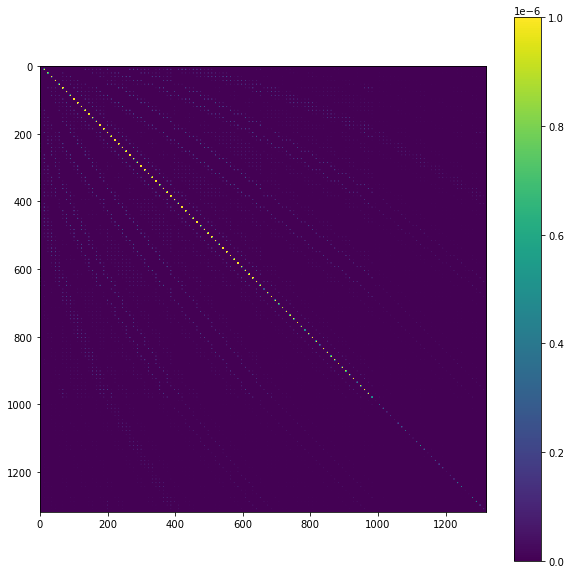

In [49]:
plt.figure(figsize=(10,10))
plt.imshow((matrix_pastis),vmin=0, vmax=1e-6)
plt.colorbar()

/opt/miniconda3/envs/pastis_global/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


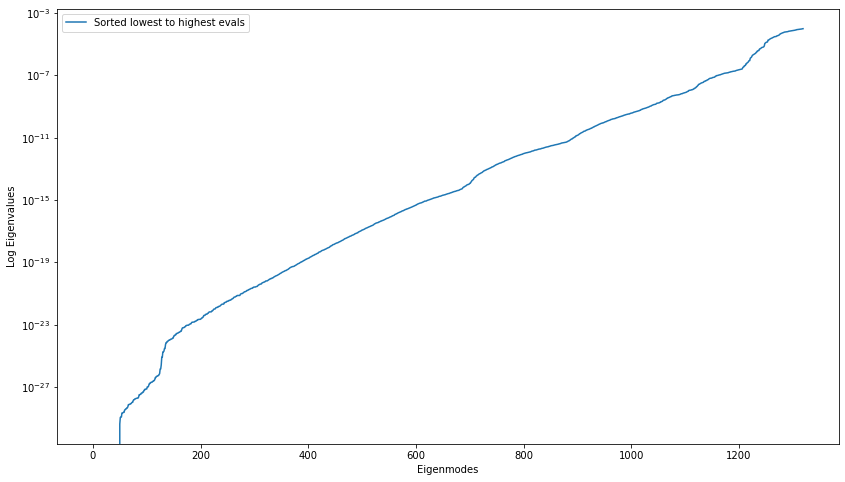

In [50]:
evals, evecs = np.linalg.eig(matrix_pastis)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(14, 8))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals, label='Sorted lowest to highest evals')
plt.semilogy()
plt.xlabel('Eigenmodes')
plt.ylabel('Log Eigenvalues')
plt.legend()

In [54]:
sorted_evecs?

In [56]:
emodes = []
eunit = 1e-9
for mode in range(len(evals)):
    print('Working on mode {}/{}.'.format(mode+1, len(evals)))
    
    harris_coeffs = eunit*sorted_evecs[:, mode]/2
    luvoir.harris_sm.actuators = harris_coeffs
    wf_harris_sm = luvoir.harris_sm(luvoir.wf_aper)
    emodes.append(wf_harris_sm.phase)

Working on mode 1/1320.
Working on mode 2/1320.
Working on mode 3/1320.
Working on mode 4/1320.
Working on mode 5/1320.
Working on mode 6/1320.
Working on mode 7/1320.
Working on mode 8/1320.
Working on mode 9/1320.
Working on mode 10/1320.
Working on mode 11/1320.
Working on mode 12/1320.
Working on mode 13/1320.
Working on mode 14/1320.
Working on mode 15/1320.
Working on mode 16/1320.
Working on mode 17/1320.
Working on mode 18/1320.
Working on mode 19/1320.
Working on mode 20/1320.
Working on mode 21/1320.
Working on mode 22/1320.
Working on mode 23/1320.
Working on mode 24/1320.


KeyboardInterrupt: 

In [63]:
first_emode=[]
for mode in range(0,10):
    print('Working on mode {}/{}.'.format(mode+1, 10))
    harris_coeffs = eunit*sorted_evecs[:, mode]/2
    luvoir.harris_sm.actuators = harris_coeffs
    wf_harris_sm = luvoir.harris_sm(luvoir.wf_aper)
    first_emode.append(wf_harris_sm.phase)

Working on mode 1/10.
Working on mode 2/10.
Working on mode 3/10.
Working on mode 4/10.
Working on mode 5/10.
Working on mode 6/10.
Working on mode 7/10.
Working on mode 8/10.
Working on mode 9/10.
Working on mode 10/10.


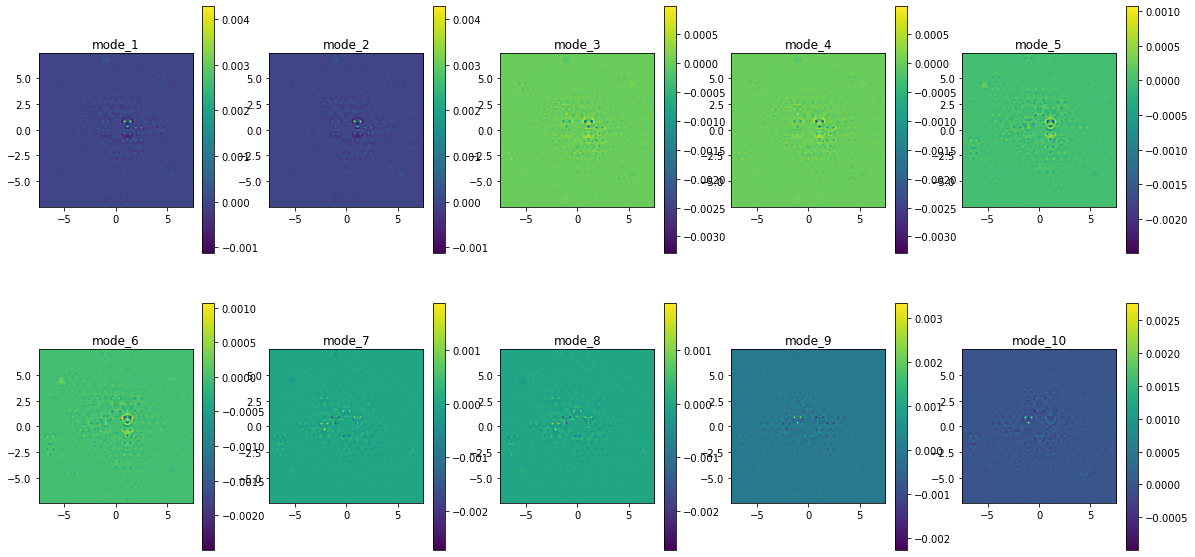

In [69]:
plt.figure(figsize=(20,10))

plt.subplot(2,5,1)
plt.title("mode_1")
hcipy.imshow_field(first_emode[0])
plt.colorbar()

plt.subplot(2,5,2)
plt.title("mode_2")
hcipy.imshow_field(first_emode[1])
plt.colorbar()

plt.subplot(2,5,3)
plt.title("mode_3")
hcipy.imshow_field(first_emode[2])
plt.colorbar()

plt.subplot(2,5,4)
plt.title("mode_4")
hcipy.imshow_field(first_emode[3])
plt.colorbar()

plt.subplot(2,5,5)
plt.title("mode_5")
hcipy.imshow_field(first_emode[4])
plt.colorbar()

plt.subplot(2,5,6)
plt.title("mode_6")
hcipy.imshow_field(first_emode[5])
plt.colorbar()

plt.subplot(2,5,7)
plt.title("mode_7")
hcipy.imshow_field(first_emode[6])
plt.colorbar()

plt.subplot(2,5,8)
plt.title("mode_8")
hcipy.imshow_field(first_emode[7])
plt.colorbar()

plt.subplot(2,5,9)
plt.title("mode_9")
hcipy.imshow_field(first_emode[8])
plt.colorbar()

plt.subplot(2,5,10)
plt.title("mode_10")
hcipy.imshow_field(first_emode[9])
plt.colorbar()

plt.show()

In [71]:
last_emode=[]
for mode in range(0,10):
    print('Working on mode {}/{}.'.format(mode+1, 10))
    harris_coeffs = eunit*sorted_evecs[:, 1319-mode]/2
    luvoir.harris_sm.actuators = harris_coeffs
    wf_harris_sm = luvoir.harris_sm(luvoir.wf_aper)
    last_emode.append(wf_harris_sm.phase)

Working on mode 1/10.
Working on mode 2/10.
Working on mode 3/10.
Working on mode 4/10.
Working on mode 5/10.
Working on mode 6/10.
Working on mode 7/10.
Working on mode 8/10.
Working on mode 9/10.
Working on mode 10/10.


IndexError: list index out of range

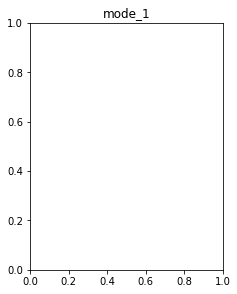

In [72]:
plt.figure(figsize=(20,10))

plt.subplot(2,5,1)
plt.title("mode_1")
hcipy.imshow_field(last_emode[0])
plt.colorbar()

plt.subplot(2,5,2)
plt.title("mode_2")
hcipy.imshow_field(last_emode[1])
plt.colorbar()

plt.subplot(2,5,3)
plt.title("mode_3")
hcipy.imshow_field(last_emode[2])
plt.colorbar()

plt.subplot(2,5,4)
plt.title("mode_4")
hcipy.imshow_field(last_emode[3])
plt.colorbar()

plt.subplot(2,5,5)
plt.title("mode_5")
hcipy.imshow_field(last_emode[4])
plt.colorbar()

plt.subplot(2,5,6)
plt.title("mode_6")
hcipy.imshow_field(last_emode[5])
plt.colorbar()

plt.subplot(2,5,7)
plt.title("mode_7")
hcipy.imshow_field(last_emode[6])
plt.colorbar()

plt.subplot(2,5,8)
plt.title("mode_8")
hcipy.imshow_field(last_emode[7])
plt.colorbar()

plt.subplot(2,5,9)
plt.title("mode_9")
hcipy.imshow_field(last_emode[1318])
plt.colorbar()

plt.subplot(2,5,10)
plt.title("mode_10")
hcipy.imshow_field(last_emode[1319])
plt.colorbar()

plt.show()

In [ ]:
# wf_active_pupil = wf_aper
# wf_active_pupil = harris_sm(wf_active_pupil)
# wf_harris_sm = harris_sm(wf_aper)

# hcipy.imshow_field(wf_active_pupil.phase)
# hcipy.imshow_field(wf_harris_sm.phase)
# hcipy.imshow_field(wf_aper.phase)

# # All E-field propagations
# wf_dm1_coro = hcipy.Wavefront(wf_active_pupil.electric_field * np.exp(4 * 1j * np.pi/wvln * self.DM1), self.wavelength)
# wf_dm2_coro_before = fresnel(wf_dm1_coro)
# wf_dm2_coro_after = hcipy.Wavefront(wf_dm2_coro_before.electric_field * np.exp(4 * 1j * np.pi / self.wavelength * self.DM2) * self.DM2_circle, self.wavelength)
# wf_back_at_dm1 = self.fresnel_back(wf_dm2_coro_after)
# wf_apod_stop = hcipy.Wavefront(wf_back_at_dm1.electric_field * self.apod_stop, self.wavelength)

# wf_before_lyot = self.coro(wf_apod_stop)
# wf_lyot = self.lyot_stop(wf_before_lyot)
# wf_lyot.wavelength = self.wavelength

# wf_im_coro = self.prop(wf_lyot)
# wf_im_ref = self.prop(wf_back_at_dm1)